In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

### Define two-site binding model with two microscopic affinities k1,k2 and cooperativity factor f

In [3]:
class SSB():
    
    def __init__(self,k1=.01,k2=.01,f=50):
        self.k1 = k1
        self.k2 = k2
        self.f = f
        self.conc_range = 1000
        self.binding_curve = np.zeros(self.conc_range)
        self.step = 1
        
        self.function = lambda x: ((k1 + k2)*x + f*2*k1*k2*x**2) / (1 + (k1 + k2)*x + f*k1*k2*x**2)
    
    def sim(self):
        self.binding_curve = [self.function(val) for val in np.arange(self.conc_range)]

#### Run function and plot binding curve

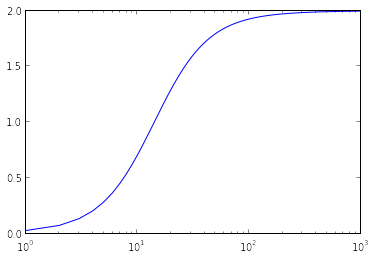

In [4]:
ssb = SSB()
ssb.sim()
plt.plot(ssb.binding_curve)
plt.xscale("log")

### Genetic algorithm
- Holds a population (size N) of SSB models
- Two main functions: procreate and select
- Procreate creates a new population of size N. New models have all 3 parameters disturbed by a Brownian motion process
- Select draws a new population of size N from old population with probabilities proportional to normalized fitness against the target binding model

In [21]:
class PhysPopulation(SSB):
    
    def __init__(self,N=100,selection_strength=10,k1=.01,k2=.01,f=50):
        
        # Biophysical model
        # Create target model on startup by simulating under binding model and populating self.binding curve
        SSB.__init__(self,k1,k2,f)
        self.sim() # get starting curve
        self.target = self.binding_curve
        self.mean_k1 = 0
        self.mean_k2 = 0
        self.mean_f = 0
        self.var_k1 = 0
        self.var_k2 = 0
        self.var_f = 0
        
        # Population parameters
        self.population = []
        self.mean_fitness = 0
        self.fitness_var = 0
        
        # Genetic algorithm params
        self.N = N
        self.selection_strength = selection_strength
        self.cost_function = self._distance_function
        self._initialize_pop()
        
        # Brownian motion params
        self.dt = .001
        
    def _update_biophys_params(self,sim=False):
        '''Update means and variances for population K1 and K2s'''
        k1s,k2s,fs = [],[],[]
        for i in self.population:
            if sim:
                i.sim()
            k1s.append(i.k1)
            k2s.append(i.k2)
            fs.append(i.f)
        self.mean_k1 = sum(k1s)/len(k1s)
        self.mean_k2 = sum(k2s)/len(k2s)
        self.mean_f = sum(fs)/len(fs)
        self.var_k1 = np.var(k1s)
        self.var_k2 = np.var(k2s)
        self.var_f = np.var(fs)
        
    def _initialize_pop(self,K_lower=0,K_upper=.1,f_lower=0,f_upper=10):
        '''Create starting population of size self.N filled with Adair models, each sampled'''
        rando = np.random.uniform
        self.population = [SSB(rando(K_lower,K_upper),
                               rando(K_lower,K_upper),
                                rando(f_lower,f_upper)) for i in range(self.N)]
        self._update_biophys_params()
        
    def _distance_function(self,target,comp):
        '''Compute abs(x-y) between two input binding curves'''
        assert len(comp) == len(target)
        return sum(map(lambda (x,y): abs(x-y), zip(target,comp)))
    
    def _pop_fitness(self):
        fitness_vec = [self.selection_strength*(1/self.cost_function(m.binding_curve,self.target))
                       for m in self.population]
        self.mean_fitness = sum(fitness_vec)/len(fitness_vec)
        self.fitness_var = np.var(fitness_vec)
        return fitness_vec
    
    def brownian(self,params=[]):
        '''Take a single brownian step over params vector'''
        out = []
        for i in params:
            new_param = i + norm.rvs(loc=0,scale=2*self.dt)
            if new_param < 0:
                new_param = 0
            out.append(new_param)
        return out
        
    def procreate(self):
        new_pop = []
        for model in self.population:
            new_k1,new_k2,new_f = self.brownian([model.k1,model.k2,model.f])
            model = SSB(new_k1,new_k2,new_f)
            model.sim() # create new binding curve
            new_pop.append(model)
        self.population = new_pop
        self._update_biophys_params(sim=False)
        
    def select(self):
        fitness_vec = self._pop_fitness()
        w_sum = sum(fitness_vec)
        w_norm = [i/w_sum for i in fitness_vec]
        new_pop = np.random.choice(self.population,self.N,p=w_norm)
        self.population = new_pop
        self._update_biophys_params(sim=False)

#### 100 rounds of selection

In [22]:
pop1 = PhysPopulation(N=100)

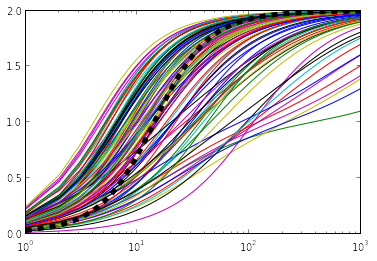

In [23]:
## Plot initial population of curves.

plt.plot()

for i in pop1.population:
    i.sim()
    plt.plot(i.binding_curve)
    
plt.plot(pop1.target,"k--",lw=5)

plt.xscale("log")

In [24]:
# Select for 100 generations
# Store mean fitness, fitness variance, and parameter variances

w1 = []
w1_var = []
k1_var1 = []
k2_var1 = []
f_var1 = []
for i in range(100):
    pop1.select()
    w1.append(pop1.mean_fitness)
    w1_var.append(pop1.fitness_var)
    k1_var1.append(pop1.var_k1)
    k2_var1.append(pop1.var_k2)
    f_var1.append(pop1.var_f)

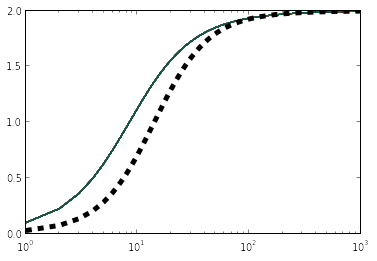

In [25]:
# Plot population after selection

for i in pop1.population:
    i.sim()
    plt.plot(i.binding_curve)
    
plt.plot(pop1.target,"k--",lw=5)

plt.xscale("log")

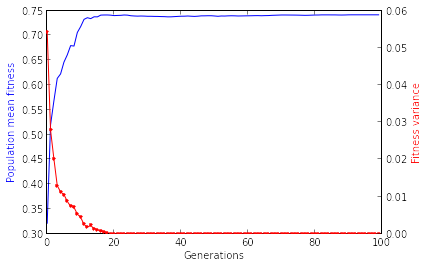

In [26]:
# Plot fitness mean and variance over generations

fig,ax1 = plt.subplots()
ax1.plot(w1,"b")
ax1.set_ylabel("Population mean fitness",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(w1_var,"r.-")
ax2.set_ylabel("Fitness variance",color="red")

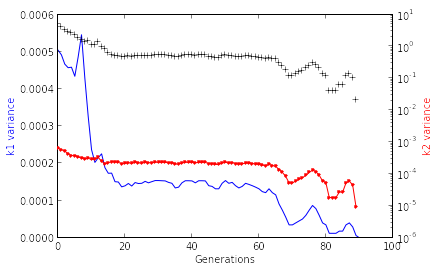

In [27]:
# Plot parameter variances: k1,k2,f

fig,ax1 = plt.subplots()
ax1.plot(k1_var1,"b")
ax1.set_ylabel("k1 variance",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(k2_var1,"r.-")
ax2.set_ylabel("k2 variance",color="red")

ax2.plot(f_var1,"k+")
plt.yscale("log")

## New population - 100 rounds of mutation/selection

In [28]:
pop2 = PhysPopulation(N=100)

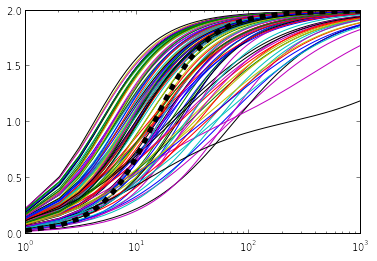

In [30]:
plt.plot()

for i in pop2.population:
    i.sim()
    plt.plot(i.binding_curve)
    
plt.plot(pop2.target,"k--",lw=5)

plt.xscale("log")

In [31]:
# Select/mutate for 100 generations

w2 = []
w2_var = []
k1_var2 = []
k2_var2 = []
f_var2 = []
for i in range(100):
    pop2.select()
    w2.append(pop2.mean_fitness)
    w2_var.append(pop2.fitness_var)
    k1_var2.append(pop2.var_k1)
    k2_var2.append(pop2.var_k2)
    f_var2.append(pop2.var_f)
    pop2.procreate()

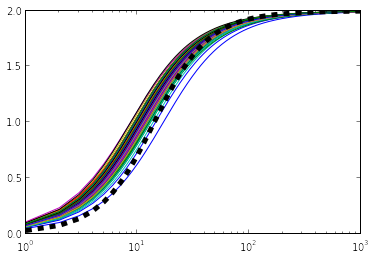

In [32]:
# Plot
plt.plot()

for i in pop2.population:
    i.sim()
    plt.plot(i.binding_curve)
    
plt.plot(pop2.target,"k--",lw=5)

plt.xscale("log")

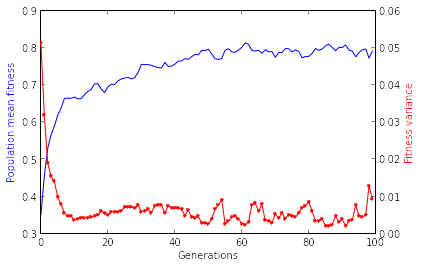

In [33]:
fig,ax1 = plt.subplots()
ax1.plot(w2,"b")
ax1.set_ylabel("Population mean fitness",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(w2_var,"r.-")
ax2.set_ylabel("Fitness variance",color="red")

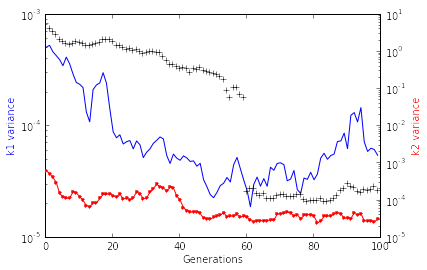

In [34]:
fig,ax1 = plt.subplots()
ax1.plot(k1_var2,"b")
ax1.set_ylabel("k1 variance",color="blue")
ax1.set_xlabel("Generations")
plt.yscale("log")

ax2 = ax1.twinx()
ax2.plot(k2_var2,"r.-")
ax2.set_ylabel("k2 variance",color="red")

ax2.plot(f_var2,"k+")

plt.yscale("log")

### Find correlations between parameters
- k1 and k2 are inversely correlated, as expected.

In [35]:
k1s = [m.k1 for m in pop2.population]
k2s = [m.k2 for m in pop2.population]
fs = [m.f for m in pop2.population]
params = pd.DataFrame({"k1":k1s, "k2":k2s, "f":fs})

In [36]:
params.corr()

,f,k1,k2
f,1.000000,-0.093545,0.279808
k1,-0.093545,1.000000,-0.410425
k2,0.279808,-0.410425,1.000000
